<a href="https://colab.research.google.com/github/CJ-99/MaSS/blob/CODE/ResNet_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
Residual Network (ResNet). We train a ResNet (7) with 32 convolutional layers. The ResNet-32
has a sequence of 15 residual blocks: the first 5 blocks have an output of shape 32 × 32 × 16, the
following 5 blocks have an output of shape 16×16×32 and the last 5 blocks have an output of shape
8×8×64. On top of these blocks, there is a 2×2 average pooling layer with stride of 2, followed by
a output layer of size 10 with softmax non-linearity. The ResNet-32 has ≈467k trainable parameters
in total.
"""

In [2]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
  
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
class ResBlock(nn.Module):
  """
  Residual block of 2 conv layers:
  Conv -> Norm -> Act -> Conv -> Norm -> Act
     |__[Optional: 1x1 Conv -> Norm]__|
  """
  def __init__(self, in_channels, mid_channels, out_channels, downsample=None):
    super().__init__()
    self.downsample = isinstance(downsample, int)
    self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, padding=1, stride=(downsample or 1))
    self.norm1 = nn.BatchNorm2d(mid_channels)
    self.act1 = nn.ReLU()
    self.conv2 = nn.Conv2d(mid_channels, out_channels, 3, padding=1)
    self.norm2 = nn.BatchNorm2d(out_channels)
    self.act2 = nn.ReLU()
    if self.downsample:
      self.convp = nn.Conv2d(in_channels, out_channels, 1, padding=0, stride=downsample)
      self.normp = nn.BatchNorm2d(out_channels)
    
  def forward(self, x):
    x_ = self.act1(self.norm1(self.conv1(x)))
    x_ = self.norm2(self.conv2(x_))
    if self.downsample:
      x = self.normp(self.convp(x))
    x = x + x_
    return self.act2(x)

    
class ResNet(nn.Module):
  def __init__(self, channels=[16,32,64],
               num_classes=10):
    super().__init__()
    self.conv1 = nn.Conv2d(3, channels[0], 3, padding=1)
    self.block1 = nn.Sequential(
                                *[
                                ResBlock(channels[0], channels[0], channels[0])
                                for i in range(5)
                                ])
    self.block2 = nn.Sequential(ResBlock(channels[0], channels[1], channels[1], downsample=2),
                                *[
                                ResBlock(channels[1], channels[1], channels[1])
                                for i in range(4)
                                ])
    self.block3 = nn.Sequential(ResBlock(channels[1], channels[2], channels[2], downsample=2),
                                *[
                                ResBlock(channels[2], channels[2], channels[2])
                                for i in range(4)
                                ])
    self.pool = nn.AvgPool2d(8)
    self.flat_channels = channels[2]
    self.fc = nn.Linear(channels[2], num_classes)
    self.prob = nn.Softmax(dim=1)

  def forward(self, x):
    B = x.shape[0]
    x = self.conv1(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.pool(x)
    x = torch.flatten(x,1)
    x = self.fc(x)
    return x

In [4]:
torch.cuda.get_device_name(0)


'Tesla T4'

In [5]:
#Quick Test
model = ResNet()
out = model(torch.rand(128,3,32,32))
print(out)

tensor([[ 0.1513, -0.0472,  0.2601,  ...,  1.6040, -0.3908,  0.1240],
        [ 0.1604,  0.0032,  0.3244,  ...,  1.3005, -0.4413,  0.4308],
        [ 0.1484,  0.1164,  0.2754,  ...,  1.2847, -0.5509,  0.3047],
        ...,
        [ 0.0709,  0.0634,  0.4891,  ...,  1.3158, -0.4576,  0.3515],
        [-0.1158, -0.1909,  0.3456,  ...,  1.2681, -0.3994,  0.1777],
        [ 0.0994, -0.0217,  0.2642,  ...,  1.5988, -0.4534,  0.3128]],
       grad_fn=<AddmmBackward0>)


In [6]:
# Hyper-parameters
num_epochs = 300
batch_size = 64
learning_rate = 0.1

In [7]:
#"Load CIFAR10 Data"
import torchvision
import torchvision.transforms as transforms
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
import torch.optim as optim

net = ResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [9]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

Epoch [1/300], Step [782/782], Loss: 0.71128
Epoch [2/300], Step [782/782], Loss: 0.63487
Epoch [3/300], Step [782/782], Loss: 0.20989
Epoch [4/300], Step [782/782], Loss: 0.06819
Epoch [5/300], Step [782/782], Loss: 0.01685
Epoch [6/300], Step [782/782], Loss: 0.31064
Epoch [7/300], Step [782/782], Loss: 0.08151
Epoch [8/300], Step [782/782], Loss: 0.37480
Epoch [9/300], Step [782/782], Loss: 0.26592
Epoch [10/300], Step [782/782], Loss: 0.20794
Epoch [11/300], Step [782/782], Loss: 0.10030
Epoch [12/300], Step [782/782], Loss: 0.63765
Epoch [13/300], Step [782/782], Loss: 0.24449
Epoch [14/300], Step [782/782], Loss: 0.07287
Epoch [15/300], Step [782/782], Loss: 0.22309
Epoch [16/300], Step [782/782], Loss: 0.16922
Epoch [17/300], Step [782/782], Loss: 0.01976
Epoch [18/300], Step [782/782], Loss: 0.06283
Epoch [19/300], Step [782/782], Loss: 0.13962
Epoch [20/300], Step [782/782], Loss: 0.00603
Epoch [21/300], Step [782/782], Loss: 0.03598
Epoch [22/300], Step [782/782], Loss: 0.000

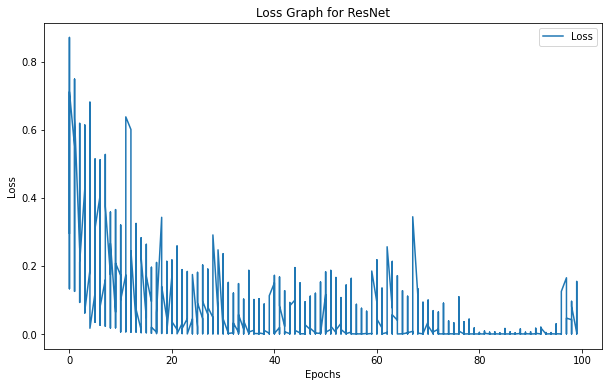

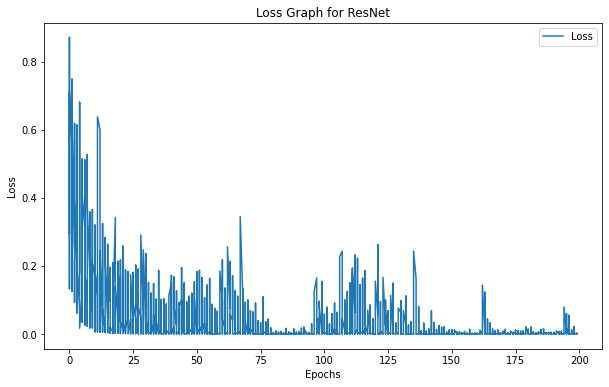

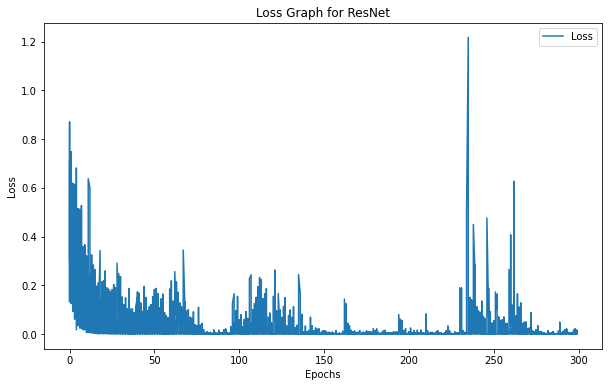

In [12]:
loss_history = []
epochs = []
n_total_steps = len(trainloader)
start_time = time.time()
for epoch in range(num_epochs):
    if epoch == 150:
        learning_rate = learning_rate/10
    if epoch == 225:
        learning_rate = learning_rate/10
    for i, (images, labels) in enumerate(trainloader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss_history.append(loss.item())
        epochs.append(epoch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 782 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.5f}')
    if (epoch+1) % 100 == 0:
        plotLosses(epochs, loss_history, 'Loss Graph for ResNet')

print("--- %s seconds ---" % (time.time() - start_time))

print('Finished Training')
PATH = './ResNet.pth'
torch.save(model.state_dict(), PATH)

In [13]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 83.55 %
Accuracy of plane: 88.0 %
Accuracy of car: 92.8 %
Accuracy of bird: 75.2 %
Accuracy of cat: 68.5 %
Accuracy of deer: 80.2 %
Accuracy of dog: 76.5 %
Accuracy of frog: 88.4 %
Accuracy of horse: 85.9 %
Accuracy of ship: 90.1 %
Accuracy of truck: 89.9 %
